In [1]:
!pip install geemap
!pip install rasterio
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import time
import geemap
import ee
from matplotlib.colors import LinearSegmentedColormap
from google.colab import drive

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 11.1 MB/s eta 0:00:00


In [2]:

# Autentication and Initialization
ee.Authenticate()
ee.Initialize(project="alessiodeluca")

drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/Environment/RemoteSensingProject/

%ls

Mounted at /content/drive/
/content/drive/My Drive/Environment/RemoteSensingProject
gee/  images/  Notebooks/  PaperEnvironmentDeLuca.pdf


In [5]:
# Definition of the Area of Interest (AOI) in Croatia
geometry = ee.Geometry.Point([16.563798, 43.496451])
roi = geometry.buffer(10000)

# Function to select the image based on the date
def get_image_by_date(collection, date):
    return collection.filterDate(date, date).first()

# Sentinel-2 image collection for July and August 2017
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
                .filterBounds(geometry) \
                .filterDate('2017-07-06', '2017-08-10')

# Extract and print the dates of the images in the collection
image_dates = collection.aggregate_array('system:time_start').getInfo()

# Convert the dates from timestamp to readable format
image_dates = [ee.Date(date).format('YYYY-MM-dd').getInfo() for date in image_dates]

# Print the dates
for i, date in enumerate(image_dates):
    print(f"Image {i + 1}: {date}")


Image 1: 2017-07-07
Image 2: 2017-07-17
Image 3: 2017-07-27
Image 4: 2017-08-06


In [6]:

print(collection.size().getInfo())

4


In [7]:
imageList = collection.toList(collection.size())

pre_fire_image = imageList.get(0)
pre_fire_image = ee.Image(pre_fire_image)

during_fire_image = imageList.get(1)
during_fire_image = ee.Image(during_fire_image)

post_fire_image = imageList.get(3)
post_fire_image = ee.Image(post_fire_image)

In [8]:
# Select bands: (B8, B12)
pre_fire_image = pre_fire_image.select(['B8', 'B12'])
during_fire_image = during_fire_image.select(['B8', 'B12'])
post_fire_image = post_fire_image.select(['B8', 'B12'])

In [9]:
# Function to export the image to Google Drive
def export_image_to_drive(image, description, folder, scale, region):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        scale=scale,
        region=region,
        maxPixels=1e13  # Allows exporting large images
    )
    task.start()

# Export images to Google Drive
export_image_to_drive(pre_fire_image, 'PreFireImageNBR', 'gee', 10, roi)
export_image_to_drive(during_fire_image, 'DuringFireNBR', 'gee', 10, roi)
export_image_to_drive(post_fire_image, 'PostFireNBR', 'gee', 10, roi)

print("Image export started.")


Image export started.


In [10]:
# Function to monitor the task status
def monitor_task(task):
    while task.active():
        print(f'Task {task.status().get("description")} is {task.status().get("state")}')
        time.sleep(10)  # Wait 10 seconds before checking again
    print(f'Task {task.status().get("description")} completed with status: {task.status().get("state")}')

# Modify the export_image_to_drive function to return the task
def export_image_to_drive(image, description, folder, scale, region):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        scale=scale,
        region=region,
        maxPixels=1e13
    )
    task.start()
    return task  # Return the task for monitoring

# Execute the export and monitor the task status with the new index
pre_fire_task = export_image_to_drive(pre_fire_image, 'PreFireImageNBR', 'gee', 10, roi)
monitor_task(pre_fire_task)

during_fire_task = export_image_to_drive(during_fire_image, 'DuringFireImageNBR', 'gee', 10, roi)
monitor_task(during_fire_task)

post_fire_task = export_image_to_drive(post_fire_image, 'PostFireImageNBR', 'gee', 10, roi)
monitor_task(post_fire_task)


Task PreFireImageNBR is READY
Task PreFireImageNBR is READY
Task PreFireImageNBR is READY
Task PreFireImageNBR is RUNNING
Task PreFireImageNBR is RUNNING
Task PreFireImageNBR is RUNNING
Task PreFireImageNBR is RUNNING
Task PreFireImageNBR is RUNNING
Task PreFireImageNBR is RUNNING
Task PreFireImageNBR is RUNNING
Task PreFireImageNBR completed with status: COMPLETED
Task DuringFireImageNBR is READY
Task DuringFireImageNBR is RUNNING
Task DuringFireImageNBR is RUNNING
Task DuringFireImageNBR is RUNNING
Task DuringFireImageNBR is RUNNING
Task DuringFireImageNBR is RUNNING
Task DuringFireImageNBR is RUNNING
Task DuringFireImageNBR is RUNNING
Task DuringFireImageNBR completed with status: COMPLETED
Task PostFireImageNBR is READY
Task PostFireImageNBR is RUNNING
Task PostFireImageNBR is RUNNING
Task PostFireImageNBR is RUNNING
Task PostFireImageNBR is RUNNING
Task PostFireImageNBR is RUNNING
Task PostFireImageNBR is RUNNING
Task PostFireImageNBR is RUNNING
Task PostFireImageNBR is RUNNING
Ta

In [11]:
# Open the .tif image
with rasterio.open('/content/drive/My Drive/Environment/RemoteSensingProject/gee/PreFireImageNBR.tif') as src:
    print(f"The image has {src.count} band(s)")


The image has 2 band(s)


Calculating and saving the PreFireImage NBR image to /content/drive/My Drive/Environment/RemoteSensingProject/images/PreFireImage.png...


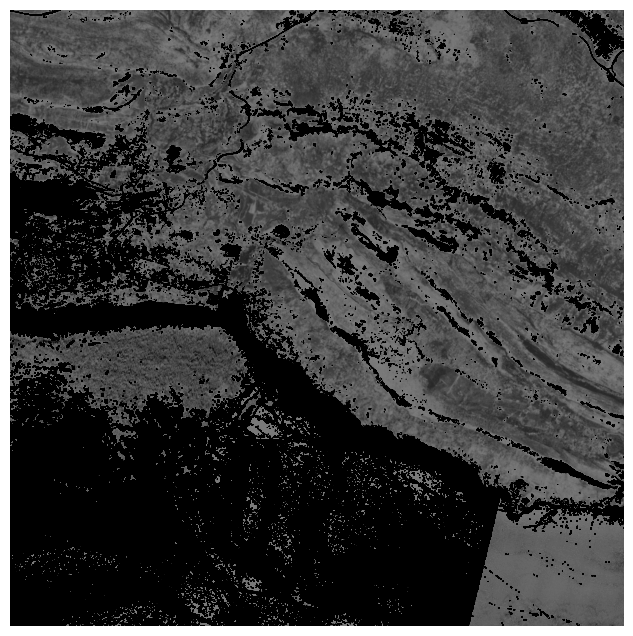

Calculating and saving the DuringFireImage NBR image to /content/drive/My Drive/Environment/RemoteSensingProject/images/DuringFireImage.png...


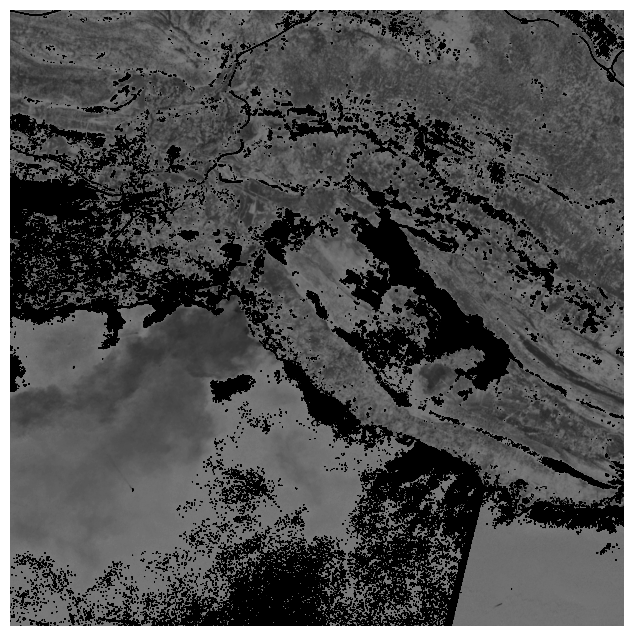

Calculating and saving the PostFireImage NBR image to /content/drive/My Drive/Environment/RemoteSensingProject/images/PostFireImage.png...


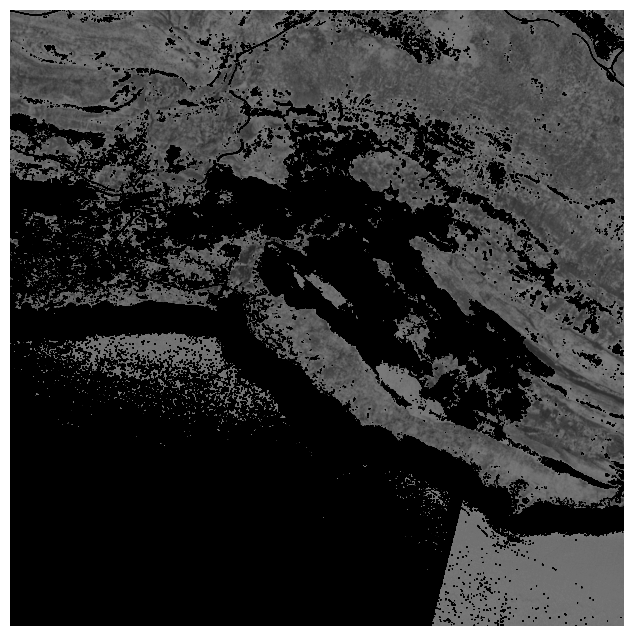

In [12]:
# Define file paths
image_paths = {
    'PreFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/gee/PreFireImageNBR.tif',
    'DuringFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/gee/DuringFireImageNBR.tif',
    'PostFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/gee/PostFireImageNBR.tif'
}

# Configure the black-and-white color map
cmap = LinearSegmentedColormap.from_list('black_white', ['white', 'black'])

# Directory to save images
output_dir = '/content/drive/My Drive/Environment/RemoteSensingProject/images/'

# Function to calculate and visualize NBR
def calculate_and_visualize_nbr(image_path, output_file):
    with rasterio.open(image_path) as src:
        # Read the NIR (B08) and SWIR (B12) bands
        nir = src.read(1)  # Assuming NIR is the first band
        swir = src.read(2)  # Assuming SWIR is the second band

    # Calculate NBR
    nbr = (nir - swir) / (nir + swir)

    # Create the figure
    plt.figure(figsize=(12, 8))
    plt.imshow(nbr, cmap=cmap, vmin=-1, vmax=1)

    # Remove axes and title
    plt.axis('off')

    # Save the image as PNG
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

    # Display the image in the Python code
    plt.figure(figsize=(12, 8))
    plt.imshow(nbr, cmap=cmap, vmin=-1, vmax=1)
    plt.axis('off')
    plt.show()

# Calculate and visualize the Pre, During, and Post-Fire NBR images
for label, path in image_paths.items():
    output_file = f"{output_dir}{label}.png"
    print(f"Calculating and saving the {label} NBR image to {output_file}...")
    calculate_and_visualize_nbr(path, output_file)


Calculating and saving the NBR difference to /content/drive/My Drive/Environment/RemoteSensingProject/images/NBR_Difference_Pre_Post.png...


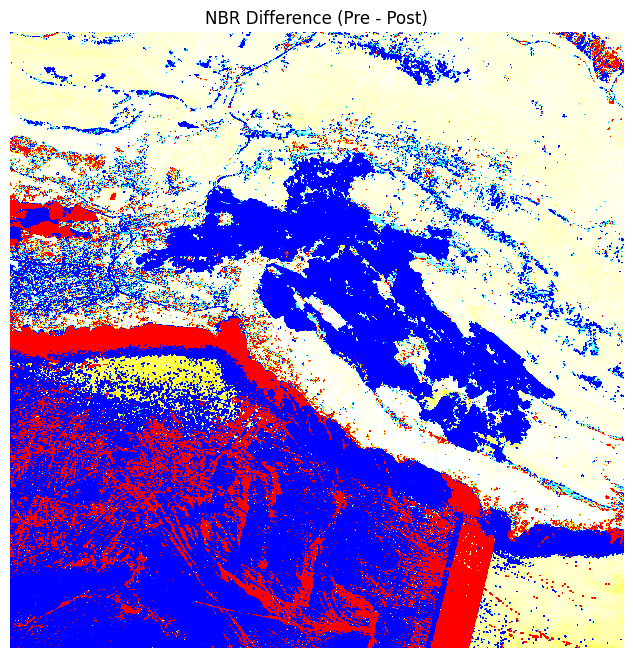

In [13]:

# Define file paths
image_paths = {
    'PreFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/gee/PreFireImageNBR.tif',
    'PostFireImage': '/content/drive/My Drive/Environment/RemoteSensingProject/gee/PostFireImageNBR.tif'
}

# Configure the color map to highlight differences
cmap = LinearSegmentedColormap.from_list('highlight_diff', ['blue', 'cyan', 'white', 'yellow', 'red'])

# Directory to save images
output_dir = '/content/drive/My Drive/Environment/RemoteSensingProject/images/'

# Function to calculate NBR
def calculate_nbr(image_path):
    with rasterio.open(image_path) as src:
        nir = src.read(1)  # Read the NIR band (B08)
        swir = src.read(2)  # Read the SWIR band (B12)

    # Calculate NBR
    nbr = (nir - swir) / (nir + swir)
    return nbr

# Function to calculate and visualize NBR difference
def calculate_and_visualize_nbr_difference(pre_fire_path, post_fire_path, output_file):
    # Calculate pre-fire and post-fire NBR
    pre_nbr = calculate_nbr(pre_fire_path)
    post_nbr = calculate_nbr(post_fire_path)

    # Calculate NBR difference (Pre - Post)
    nbr_difference = pre_nbr - post_nbr

    # Visualize the NBR difference
    plt.figure(figsize=(12, 8))
    plt.imshow(nbr_difference, cmap=cmap, vmin=-1, vmax=1)

    # Remove axes
    plt.axis('off')

    # Set title in English
    plt.title('NBR Difference (Pre - Post)', fontsize=14)

    # Save the image as PNG
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

    # Display the image in the Python code
    plt.figure(figsize=(12, 8))
    plt.imshow(nbr_difference, cmap=cmap, vmin=-1, vmax=1)
    plt.axis('off')
    plt.title('NBR Difference (Pre - Post)')
    plt.show()

# Calculate and visualize the NBR difference
output_file = f"{output_dir}NBR_Difference_Pre_Post.png"
print(f"Calculating and saving the NBR difference to {output_file}...")
calculate_and_visualize_nbr_difference(image_paths['PreFireImage'], image_paths['PostFireImage'], output_file)
